### Mixture models / Logistic Regression   

Aims to solve implanaced classification problem

In [14]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize
import pymc3 as pm
import arviz as az
sns.set()

In [15]:
df = sns.load_dataset('iris').query("species == ('setosa', 'versicolor')")

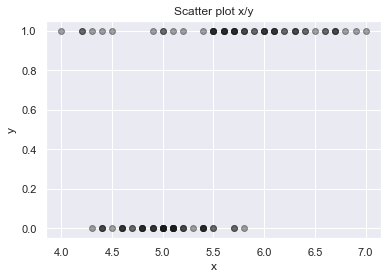

In [23]:
x = df['sepal_length'].values
y = pd.Categorical(df['species']).codes
y = np.concatenate((y, np.ones(6)))
x = np.concatenate((x, [4.2, 4.5, 4.0, 4.3, 4.2, 4.4]))

plt.scatter(x,y, alpha = 0.4, color = 'k')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatter plot x/y')
plt.show()

In [24]:
x_norm = x - x.mean()

Now that you centrlized x to x_norm, regress a logistic function against y ~ x_norm   
such that $y ~ \frac{1}{1 + e^{-(\alpha + \beta xnorm)}}$                  
then: $y ~ \frac{1}{1 + e^{-(\alpha - \beta x_mean + \beta x)}}$               
True alpha = alpha - beta * x_mean

In [ ]:
with pm.Model() as model:
    alpha_alt = pm.Normal('alpha_alt',mu = 0, sigma = 100)
    beta = pm.Normal('beta', mu = 0, sd = 10)
    
    mu = pm.Deterministic('mu', alpha_alt + beta* x)
    psi = pm.Beta('psi',1,1)
    p = pm.Deterministic('p', )
    